In [113]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# DB Import


In [114]:
con = sqlite3.connect("./database/db_mepram_sepsis.sqlite3")

cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]

dataframes = {}
for table in tables:
    print(f"Cargando la tabla: {table}")
    dataframes[table] = pd.read_sql_query(f"SELECT * FROM {table}", con)
con.close()


Cargando la tabla: tbl_master
Cargando la tabla: tbl_paciente
Cargando la tabla: tbl_comorbilidad
Cargando la tabla: tbl_factores_riesgo_bmr
Cargando la tabla: tbl_sintomas
Cargando la tabla: tbl_signos
Cargando la tabla: tbl_sepsis
Cargando la tabla: tbl_infecciones_previas
Cargando la tabla: tbl_colonizaciones_previas
Cargando la tabla: tbl_tratamiento_antibiotico_previo
Cargando la tabla: tbl_tratamiento_empirico
Cargando la tabla: tbl_hemocultivo_de_urgencias
Cargando la tabla: tbl_otros_cultivos_en_urgencias
Cargando la tabla: tbl_codes2names


# tbl_comorbilidad

In [115]:
tbl_comorbilidad = dataframes['tbl_comorbilidad']
tbl_comorbilidad = pd.get_dummies(tbl_comorbilidad, columns=["tipo_cancer","tipo_hepatopatia"])
print(tbl_comorbilidad)

      person_id fecha_ingreso_urgencias  infarto  insuficiencia_cardiaca  evp  \
0             1              2021-04-22      0.0                     0.0  0.0   
1             2              2021-05-07      0.0                     0.0  0.0   
2             3              2021-06-04      0.0                     0.0  0.0   
3             4              2021-06-22      0.0                     0.0  0.0   
4             5              2021-03-24      0.0                     0.0  0.0   
...         ...                     ...      ...                     ...  ...   
2562       2564              2023-02-20      0.0                     0.0  0.0   
2563       2565              2023-02-21      0.0                     0.0  0.0   
2564       2566              2023-02-27      0.0                     0.0  0.0   
2565       2567              2023-03-03      0.0                     0.0  0.0   
2566       2568              2023-03-10      0.0                     0.0  0.0   

      e_cerebrovascular  de

# tbl_factores_riesgo_bmr

In [116]:
tbl_factores_riesgo_bmr = dataframes['tbl_factores_riesgo_bmr']

# tbl_sintomas

Transformadas a columnas (sintoma1: duracion del sintoma, sintoma2...)

In [117]:
tbl_sintomas = dataframes['tbl_sintomas']
tbl_sintomas["sintoma"] = tbl_sintomas["sintoma"].astype(str)
tbl_sintomas["sintoma"] = "sintoma_" + tbl_sintomas["sintoma"]
tbl_sintomas_pivoted = tbl_sintomas.pivot_table(
    index=["person_id", "fecha_ingreso_urgencias"],  
    columns="sintoma",
    values="duracion_sintoma",
    aggfunc="sum",
    fill_value=0).reset_index()

sintoma  person_id fecha_ingreso_urgencias  sintoma_1.0  sintoma_10.0  \
0                1              2021-04-22          2.0           0.0   
1                2              2021-05-07          2.0           0.0   
2                3              2021-06-04          2.0           0.0   
3                4              2021-06-22          1.0           0.0   
4                5              2021-03-24          1.0           0.0   
...            ...                     ...          ...           ...   
2562          2564              2023-02-20          0.0           0.0   
2563          2565              2023-02-21          1.0           0.0   
2564          2566              2023-02-27          1.0           0.0   
2565          2567              2023-03-03          1.0           0.0   
2566          2568              2023-03-10          1.0           0.0   

sintoma  sintoma_11.0  sintoma_12.0  sintoma_13.0  sintoma_14.0  sintoma_15.0  \
0                 0.0           0.0       

# tbl_signos

Limpieza de caracteres especiales de la tabla
Nueva variable de fiebre: ordinal (0=hipotermia, 1=tªnormal, 2=fiebre)
Corrección de variables para reducir NAs:
- Hipotensión = tension_arterial <= 100
- Taquipnea = frec_respiratoria > 20
- Taquicardia = frec_cardiaca >90

In [118]:
tbl_signos = dataframes['tbl_signos']

for col in tbl_signos.columns[2:]:
    tbl_signos[col] = tbl_signos[col].apply(lambda x: re.findall(r'\d+\.\d+|\d+', str(x)))
    tbl_signos[col] = tbl_signos[col].apply(lambda x: float(x[0]) if x else None)

tbl_signos['fiebre'] = np.where(tbl_signos['temperatura'] >= 38, 'hipertermia',
                                np.where(tbl_signos['temperatura'] >= 36, 'normotermia', 'hipotermia'))
tbl_signos['fiebre'] = tbl_signos['fiebre'].where(tbl_signos['temperatura'].notna())

tbl_signos = tbl_signos.drop(columns=['hipotermia_hipertermia'])
tbl_signos['hipotension'] = np.where(tbl_signos['tension_arterial'].isna(), np.nan,
                                     np.where(tbl_signos['tension_arterial'] <= 100, 1, 0))
tbl_signos['taquipnea'] = np.where(tbl_signos['frec_respiratoria'].isna(), np.nan,
                                   np.where(tbl_signos['frec_respiratoria'] > 20, 1, 0))
tbl_signos['taquicardia'] = np.where(tbl_signos['frec_cardiaca'].isna(), np.nan,
                                     np.where(tbl_signos['frec_cardiaca'] >90, 1, 0))


      person_id fecha_ingreso_urgencias  temperatura  frec_cardiaca  \
0             1              2021-04-22         37.2          170.0   
1             2              2021-05-07         37.0           80.0   
2             3              2021-06-04         37.9           97.0   
3             4              2021-06-22         37.8          104.0   
4             5              2021-03-24         39.0           73.0   
...         ...                     ...          ...            ...   
2562       2564              2023-02-20         37.8          114.0   
2563       2565              2023-02-21         38.4          132.0   
2564       2566              2023-02-27         39.0          106.0   
2565       2567              2023-03-03         37.2           75.0   
2566       2568              2023-03-10         38.5          100.0   

      taquicardia  frec_respiratoria  taquipnea  tension_arterial  \
0             1.0               20.0        0.0              78.0   
1        

# tbl_sepsis

Eliminación de caracteres especiales, limpieza y recodificación.
- Lactato_serico > 2 (Si/No)(1/0)

In [119]:
tbl_sepsis = dataframes['tbl_sepsis']
tbl_sepsis['lactato_serico'] = np.where(tbl_sepsis['lactato_serico'] == '<= 2 millimole per liter', 0, 1)
for col in tbl_sepsis.columns[2:]:
    tbl_sepsis[col] = tbl_sepsis[col].apply(lambda x: re.findall(r'\d+\.\d+|\d+', str(x)))
    tbl_sepsis[col] = tbl_sepsis[col].apply(lambda x: float(x[0]) if len(x) > 0 else None)
print(tbl_sepsis)

      person_id fecha_ingreso_urgencias  foco  sepsis  shock_septico  sofa  \
0             1              2021-04-22   1.0     0.0            0.0   6.0   
1             2              2021-05-07   8.0     0.0            0.0   4.0   
2             3              2021-06-04  12.0     0.0            0.0   5.0   
3             4              2021-06-22  12.0     0.0            0.0   6.0   
4             5              2021-03-24   1.0     0.0            0.0   4.0   
...         ...                     ...   ...     ...            ...   ...   
2562       2564              2023-02-20   3.0     1.0            0.0   7.0   
2563       2565              2023-02-21   4.0     0.0            0.0   1.0   
2564       2566              2023-02-27   3.0     0.0            0.0   5.0   
2565       2567              2023-03-03   4.0     0.0            0.0   0.0   
2566       2568              2023-03-10   4.0     0.0            0.0   1.0   

      respiracion  snc_glasgow  cardiovascular  bilirrubina  pl

# tbl_infecciones_previas

### Recodificación de microorganismos y dummy vars: 
- Categorias restantes: "Enterococcus faecium", "Staphylococcus aureus", "Klebsiella pneumoniae",
    "Acinetobacter baumannii", "Pseudomonas aeruginosa", "Enterobacter species", "Other".

### Calculo de eventos y tiempo medio entre eventos/paciente

- Se calcula el número de eventos por paciente (número de infecciones previas)
- Se calcula el tiempo entre eventos y en el caso de pacientes con >2 eventos, se calcula el tiempo medio. 

In [120]:
tbl_infecciones_previas = dataframes['tbl_infecciones_previas']

codes = dataframes['tbl_codes2names']
codes = codes[codes['variable'] == "microorganism_infec_prev"]
codes = codes[['name', 'value']].rename(columns= {'value': 'microorganism_infec_prev'})
codes['name'] = codes['name'].str.extract(r'\|\s*(.*)')
codes['microorganism_infec_prev'] = codes['microorganism_infec_prev'].astype(int)
 
tbl_infecciones_previas['microorganism_infec_prev'] = tbl_infecciones_previas['microorganism_infec_prev'].astype(int)
tbl_infecciones_previas_mer = tbl_infecciones_previas.merge(codes, how=('left'), left_on='microorganism_infec_prev', right_on='microorganism_infec_prev')

eskape_microorganismos = [
    "Enterococcus faecium", "Staphylococcus aureus", "Klebsiella pneumoniae",
    "Acinetobacter baumannii", "Pseudomonas aeruginosa"
]

def clasificar_microorganismo(nombre):
    if "Enterobacter" in nombre:
        return "Enterobacter species"
    elif nombre in eskape_microorganismos:
        return nombre
    else:
        return "others"

# Pasamos a dummy los microorganismos y rellenamos la información con el sumatorio de cada dummy. De este modo no perdemos información.
# Finalmente lo almacenamos en tbl_infecciones_previas_microorganismo
tbl_infecciones_previas_mer['grupo_microorganismo'] = tbl_infecciones_previas_mer['name'].apply(clasificar_microorganismo)
tbl_infecciones_previas_mer = tbl_infecciones_previas_mer.drop(columns=['microorganism_infec_prev', 'name'])
tbl_infecciones_previas_mer['dummy'] = 1
tbl_infecciones_previas_mer[['person_id','fecha_ingreso_urgencias','dummy', 'grupo_microorganismo']]
tbl_infecciones_previas_microorganismos = tbl_infecciones_previas_mer.pivot_table(
    index=["person_id", "fecha_ingreso_urgencias"],  
    columns="grupo_microorganismo",
    values="dummy",
    aggfunc="max",
    fill_value=0).reset_index()

# tbl con el fenotipo en dummy.
tbl_infecciones_previas_fenoBMR = tbl_infecciones_previas[['person_id','fecha_ingreso_urgencias','feno_resist_infec_prev','sindrome_infeccioso', 'bmr_infec_previa']]
tbl_infecciones_previas_fenoBMR = pd.get_dummies(tbl_infecciones_previas_fenoBMR, columns=['feno_resist_infec_prev','sindrome_infeccioso'])
tbl_infecciones_previas_fenoBMR = tbl_infecciones_previas_fenoBMR.groupby(['person_id', 'fecha_ingreso_urgencias'], as_index=False).max()


In [121]:
# Calculo del número de eventos por paciente y el tiempo medio entre cada visita. 

tbl_visitas_ip = tbl_infecciones_previas
fechas_invalidas = tbl_visitas_ip[~tbl_visitas_ip['fecha_infeccion'].str.match(r'\d{4}-\d{2}-\d{2}')]
tbl_visitas_ip.loc[tbl_visitas_ip['fecha_infeccion'] == '323-05-01', 'fecha_infeccion'] = '2023-05-01'
tbl_visitas_ip['fecha_infeccion'] = pd.to_datetime(tbl_visitas_ip['fecha_infeccion'])
tbl_visitas_ip = tbl_visitas_ip[['person_id', 'fecha_ingreso_urgencias', 'fecha_infeccion']]
num_visitas = tbl_visitas_ip.groupby('person_id')['fecha_infeccion'].nunique().reset_index(name='numero_visitas')


In [122]:
# Calculo del tiempo entre las visitas en aquellos pacientes que tenga más de 1 visita

tbl_visitas_ip = tbl_visitas_ip.sort_values(by=['person_id','fecha_infeccion'])
num_dias = tbl_visitas_ip
num_dias['numero_dias'] = num_dias.groupby('person_id')['fecha_infeccion'].diff().dt.days
num_dias = num_dias[(num_dias['numero_dias'] > 0) & (num_dias['numero_dias'].notna())]
num_dias = num_dias.groupby('person_id')['numero_dias'].mean().reset_index()



In [123]:
# Calculo de dias desde desde la última infección hasta el ingreso

tbl_visitas_ip['fecha_ingreso_urgencias'] = pd.to_datetime(tbl_visitas_ip['fecha_ingreso_urgencias'])
ultima_infeccion = tbl_visitas_ip.groupby('person_id')['fecha_infeccion'].max().reset_index(name= 'ultima_fecha')
ultima_infeccion['ultima_fecha'] = pd.to_datetime(ultima_infeccion['ultima_fecha'])
fecha_ingreso_unica = tbl_visitas_ip[['person_id', 'fecha_ingreso_urgencias']].drop_duplicates()
ultima_infeccion_df = ultima_infeccion.merge(fecha_ingreso_unica, on='person_id')
ultima_infeccion_df['tiempo_ultima'] = (ultima_infeccion_df['fecha_ingreso_urgencias'] - ultima_infeccion_df['ultima_fecha']).dt.days

In [124]:
# merge infecciones previas

tbl_infecciones_complete = tbl_infecciones_previas_microorganismos.merge(tbl_infecciones_previas_fenoBMR, on= ['person_id'], how= 'left')
tbl_infecciones_complete = tbl_infecciones_complete.merge(num_visitas, on= ['person_id'], how= 'left')
tbl_infecciones_complete = tbl_infecciones_complete.merge(num_dias, on= ['person_id'], how= 'left')
tbl_infecciones_complete = tbl_infecciones_complete.merge(ultima_infeccion_df, on= ['person_id'], how= 'left')
tbl_infecciones_complete = tbl_infecciones_complete.drop(columns=['fecha_ingreso_urgencias_y'])

# tbl_colonizaciones_previas

### Recodificación de microorganismos y dummy vars: 
- Categorias restantes: "Enterococcus faecium", "Staphylococcus aureus", "Klebsiella pneumoniae",
    "Acinetobacter baumannii", "Pseudomonas aeruginosa", "Enterobacter species", "Other".

### Calculo de eventos y tiempo medio entre eventos/paciente

- Se calcula el número de eventos por paciente (número de infecciones previas)
- Se calcula el tiempo entre eventos y en el caso de pacientes con >2 eventos, se calcula el tiempo medio. 

In [125]:
tbl_colonizaciones_previas = dataframes['tbl_colonizaciones_previas']

codes_cp = dataframes['tbl_codes2names']
codes_cp = codes_cp[codes_cp['variable'] == "microorganism_colonizador"]
codes_cp = codes_cp[['name', 'value']].rename(columns= {'value': 'microorganism_colonizador'})
codes_cp['name'] = codes_cp['name'].str.extract(r'\|\s*(.*)')
codes_cp['microorganism_colonizador'] = codes_cp['microorganism_colonizador'].astype(int)

tbl_colonizaciones_previas['microorganism_colonizador'] = tbl_colonizaciones_previas['microorganism_colonizador'].astype(int)
tbl_colonizaciones_previas_mer = tbl_colonizaciones_previas.merge(codes_cp, how=('left'), left_on='microorganism_colonizador', right_on='microorganism_colonizador')

# Pasamos a dummy los microorganismos y rellenamos la información con el sumatorio de cada dummy. De este modo no perdemos información.
# Finalmente lo almacenamos en tbl_colonizaciones_previas_microorganismo
tbl_colonizaciones_previas_mer['grupo_microorganismo'] = tbl_colonizaciones_previas_mer['name'].apply(clasificar_microorganismo)
tbl_colonizaciones_previas_mer = tbl_colonizaciones_previas_mer.drop(columns=['microorganism_colonizador', 'name'])

# tbl con los microorganismos
tbl_colonizaciones_previas_mer['dummy'] = 1
tbl_colonizaciones_previas_mer = tbl_colonizaciones_previas_mer[['person_id','fecha_ingreso_urgencias', 'grupo_microorganismo', 'dummy']]
tbl_colonizaciones_previas_microorganismos = tbl_colonizaciones_previas_mer.pivot_table(
    index=["person_id", "fecha_ingreso_urgencias"],  
    columns="grupo_microorganismo",
    values="dummy",
    aggfunc="max",
    fill_value=0).reset_index()

# tbl con el fenotipo en dummy.
tbl_colonizaciones_previas_fenoBMR = tbl_colonizaciones_previas[['person_id','fecha_ingreso_urgencias','feno_resist_colo', 'bmr_colonizador']]
tbl_colonizaciones_previas_fenoBMR = pd.get_dummies(tbl_colonizaciones_previas_fenoBMR, columns=['feno_resist_colo'])
tbl_colonizaciones_previas_fenoBMR = tbl_colonizaciones_previas_fenoBMR.groupby(['person_id', 'fecha_ingreso_urgencias'], as_index=False).max()

In [126]:
# Calculo del número de eventos por paciente y el tiempo medio entre cada visita. 

tbl_visitas_cp = tbl_colonizaciones_previas
fechas_invalidas = tbl_visitas_cp[~tbl_visitas_cp['fecha_colonizacion'].str.match(r'\d{4}-\d{2}-\d{2}')]
tbl_visitas_cp['fecha_colonizacion'] = pd.to_datetime(tbl_visitas_cp['fecha_colonizacion'])
tbl_visitas_cp = tbl_visitas_cp[['person_id', 'fecha_ingreso_urgencias', 'fecha_colonizacion']]
num_visitas = tbl_visitas_cp.groupby('person_id')['fecha_colonizacion'].nunique().reset_index(name='numero_visitas')

# Calculo del tiempo entre las visitas en aquellos pacientes que tenga más de 1 visita
tbl_visitas_cp = tbl_visitas_cp.sort_values(by=['person_id','fecha_colonizacion'])
num_dias = tbl_visitas_cp
num_dias['numero_dias'] = num_dias.groupby('person_id')['fecha_colonizacion'].diff().dt.days
num_dias = num_dias[(num_dias['numero_dias'] > 0) & (num_dias['numero_dias'].notna())]
num_dias = num_dias.groupby('person_id')['numero_dias'].mean().reset_index()

# Calculo de dias desde desde la última colonización hasta el ingreso

tbl_visitas_cp['fecha_ingreso_urgencias'] = pd.to_datetime(tbl_visitas_cp['fecha_ingreso_urgencias'])
ultima_colonizacion = tbl_visitas_cp.groupby('person_id')['fecha_colonizacion'].max().reset_index(name= 'ultima_fecha')
ultima_colonizacion['ultima_fecha'] = pd.to_datetime(ultima_colonizacion['ultima_fecha'])
fecha_ingreso_unica = tbl_visitas_cp[['person_id', 'fecha_ingreso_urgencias']].drop_duplicates()
ultima_colo_df = ultima_colonizacion.merge(fecha_ingreso_unica, on='person_id')
ultima_colo_df['tiempo_ultima'] = (ultima_colo_df['fecha_ingreso_urgencias'] - ultima_colo_df['ultima_fecha']).dt.days

In [127]:
# merge infecciones previas

tbl_colo_complete = tbl_colonizaciones_previas_microorganismos.merge(tbl_colonizaciones_previas_fenoBMR, on= ['person_id'], how= 'left')
tbl_colo_complete = tbl_colo_complete.merge(num_visitas, on= ['person_id'], how= 'left')
tbl_colo_complete = tbl_colo_complete.merge(num_dias, on= ['person_id'], how= 'left')
tbl_colo_complete = tbl_colo_complete.merge(ultima_infeccion_df, on= ['person_id'], how= 'left')
tbl_colo_complete = tbl_colo_complete.drop(columns=['fecha_ingreso_urgencias_y'])

Hay que revisar y corregir las dummy de los microorganismos, fenotipo y BMR.

# tbl_tratamiento_antibiotico_previo

 - Calculamos el número de tratamientos (número de fármacos distintos administrados por paciente)
 - Calculamos el número de cambios de tratamiento (puede suponerse que se debe a un fallo en la respuesta y por lo tanto resistencia)
 - Generamos variables dummy y completamos los campos con la duración del tratamiento (días)
 - Calculamos el tiempo transcurrido desde a suministración del último tratamiento

In [128]:
tbl_tratamiento_previo = dataframes['tbl_tratamiento_antibiotico_previo']
tbl_tratamiento_previo_dias = tbl_tratamiento_previo
# Eliminamos variables no importantes

tbl_tratamiento_previo = tbl_tratamiento_previo.drop(columns=['via_administ_antib_prev', 'fecha_ingreso_urgencias'])


df_num_tratamientos = tbl_tratamiento_previo.groupby('person_id')['antimicrobiano_previo'].nunique().reset_index()
df_num_tratamientos = df_num_tratamientos.rename(columns={'antimicrobiano_previo': 'numero_tratamientos'})

df_num_cambios_tratamiento = tbl_tratamiento_previo.groupby('person_id', as_index=False).apply(
    lambda x: x[['fecha_administracion_antib', 'antimicrobiano_previo']].drop_duplicates().shape[0]
).reset_index(drop=True)

df_num_cambios_tratamiento.columns = ['person_id', 'numero_cambios_tratamiento']

df_farmaco_dummies = tbl_tratamiento_previo.pivot_table(index="person_id", columns='antimicrobiano_previo', values='dias_trat_antimicrobiano', aggfunc='sum', fill_value=0)
df_farmaco_dummies = df_farmaco_dummies.add_prefix('duracion_') 

# Calculo del tiempo transcurrido desde la administración del último tratamiento hasta el ingreso. 

tbl_tratamiento_previo_dias['fecha_administracion_antib'] = pd.to_datetime(tbl_tratamiento_previo_dias['fecha_administracion_antib'], errors='coerce')
tbl_tratamiento_previo_dias['fecha_ingreso_urgencias'] = pd.to_datetime(tbl_tratamiento_previo_dias['fecha_ingreso_urgencias'], errors='coerce')

tbl_tratamiento_previo_dias = tbl_tratamiento_previo_dias[['person_id', 'fecha_ingreso_urgencias','fecha_administracion_antib']]
tbl_tratamiento_previo_dias = tbl_tratamiento_previo_dias.sort_values(by=['person_id', 'fecha_administracion_antib'])

tbl_ultimo_tratamiento = tbl_tratamiento_previo_dias.groupby('person_id').apply(
    lambda x: x[x['fecha_administracion_antib'] <= x['fecha_ingreso_urgencias'].max()]['fecha_administracion_antib'].max()
).reset_index()
tbl_ultimo_tratamiento.columns = ['person_id', 'ultima_fecha_tratamiento']
tbl_tratamiento_previo_dias = tbl_tratamiento_previo_dias.merge(tbl_ultimo_tratamiento, on='person_id', how='left')
tbl_tratamiento_previo_dias['dias_desde_ultimo_tratamiento'] = (tbl_tratamiento_previo_dias['fecha_ingreso_urgencias'] - tbl_tratamiento_previo_dias['ultima_fecha_tratamiento']).dt.days
tbl_tratamiento_previo_dias = tbl_tratamiento_previo_dias[['person_id', 'dias_desde_ultimo_tratamiento']]
tbl_tratamiento_previo_dias = tbl_tratamiento_previo_dias.drop_duplicates(subset=['person_id'])

df_tratamiento_complete = df_num_tratamientos.merge(tbl_tratamiento_previo_dias, on="person_id").merge(df_num_cambios_tratamiento, on="person_id").merge(df_farmaco_dummies, on="person_id")


/tmp/ipykernel_204825/2474592876.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_num_cambios_tratamiento = tbl_tratamiento_previo.groupby('person_id', as_index=False).apply(
/tmp/ipykernel_204825/2474592876.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tbl_ultimo_tratamiento = tbl_tratamiento_previo_dias.groupby('person_id').apply(


# Merge 

Combinación del dataset hasta este punto.

In [129]:
df_pacientes = dataframes['tbl_paciente']


df_merged = df_pacientes.merge(tbl_comorbilidad, on = ['person_id', 'fecha_ingreso_urgencias'], how= 'left')
df_merged = df_merged.merge(tbl_factores_riesgo_bmr, on = ['person_id', 'fecha_ingreso_urgencias'], how= 'left')
df_merged = df_merged.merge(tbl_sepsis, on= ['person_id', 'fecha_ingreso_urgencias'], how= 'left')
df_merged = df_merged.merge(tbl_signos, on= ['person_id', 'fecha_ingreso_urgencias'], how= 'left')
df_merged = df_merged.merge(tbl_sintomas_pivoted, on= ['person_id', 'fecha_ingreso_urgencias'], how= 'left')
df_merged = df_merged.merge(tbl_infecciones_complete, on= ['person_id'], how= 'left')
df_merged = df_merged.merge(tbl_colo_complete, on= ['person_id'], how= 'left')
df_merged = df_merged.merge(df_tratamiento_complete, on= ['person_id'], how= 'left')

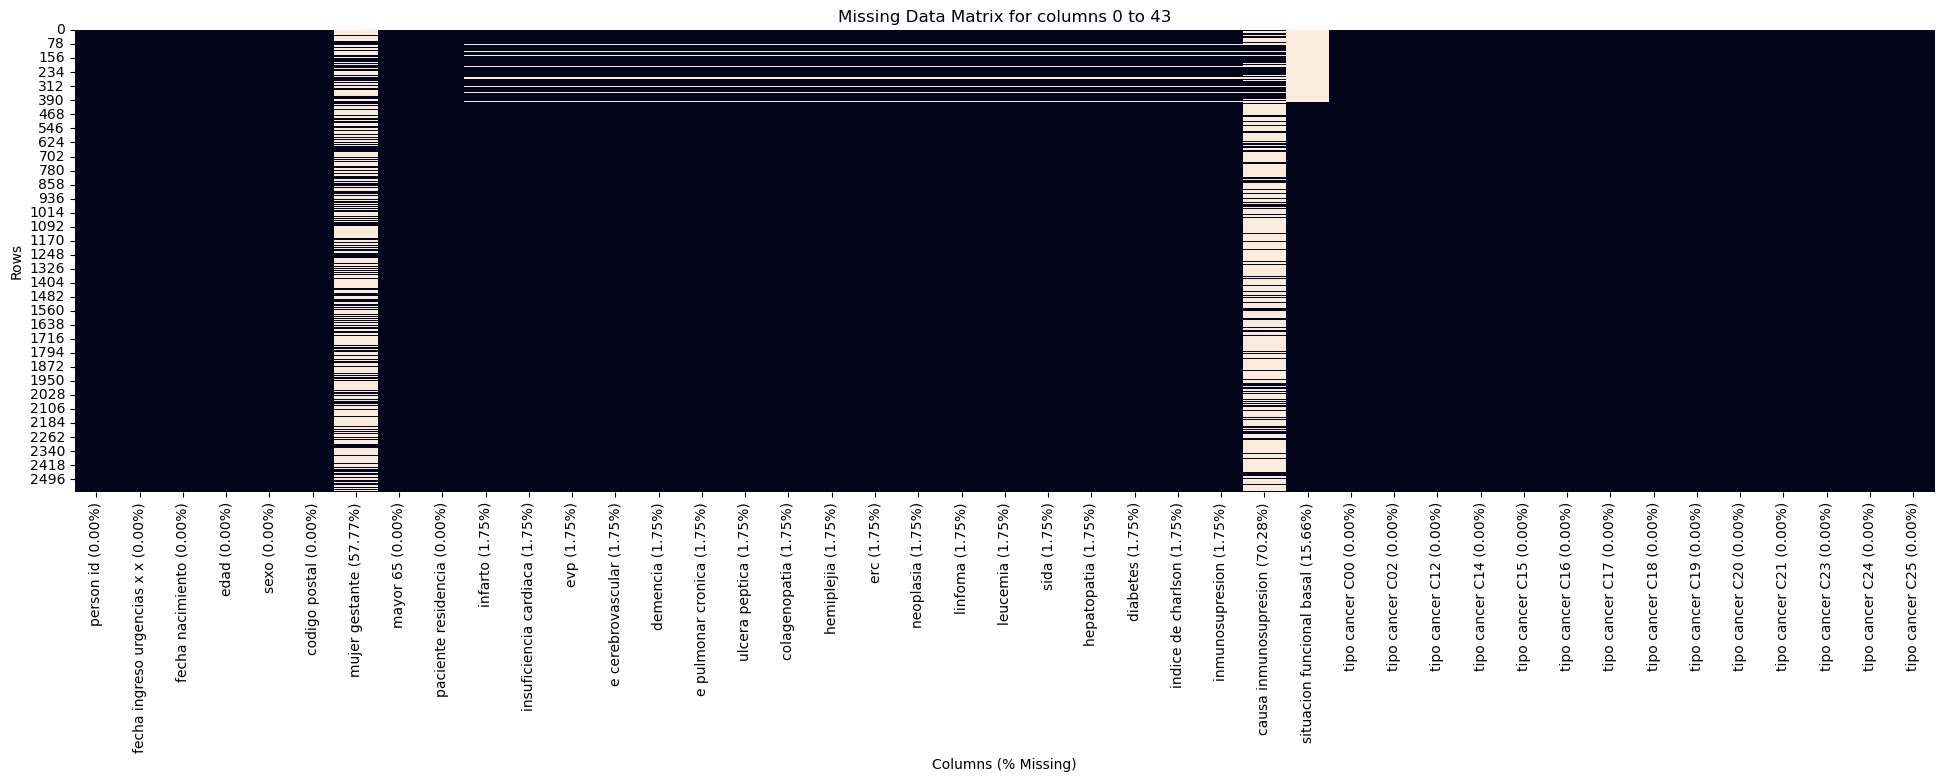

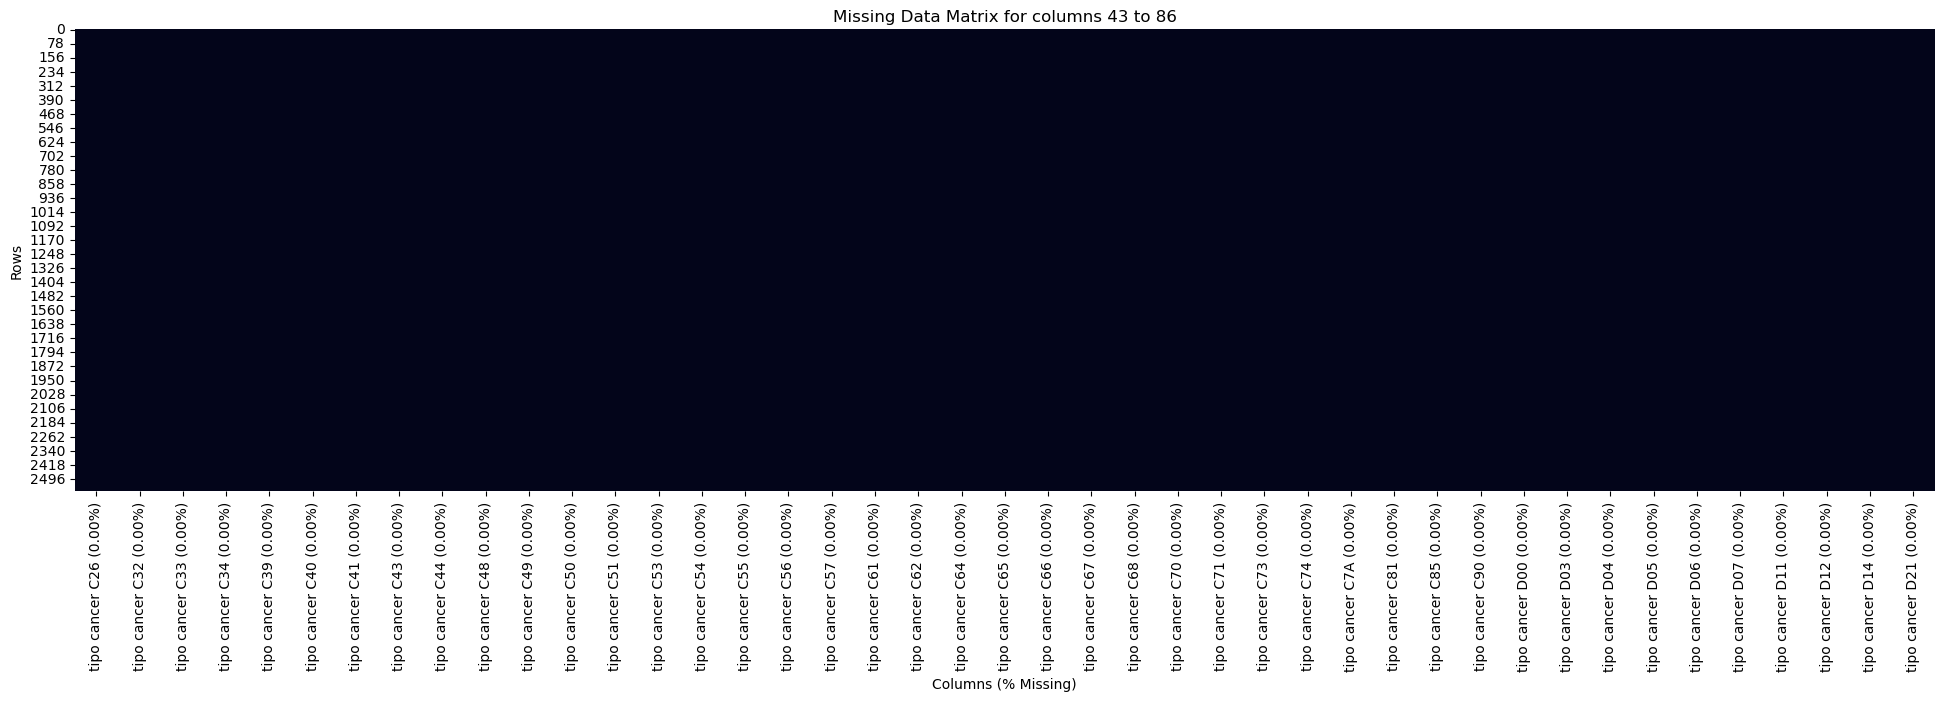

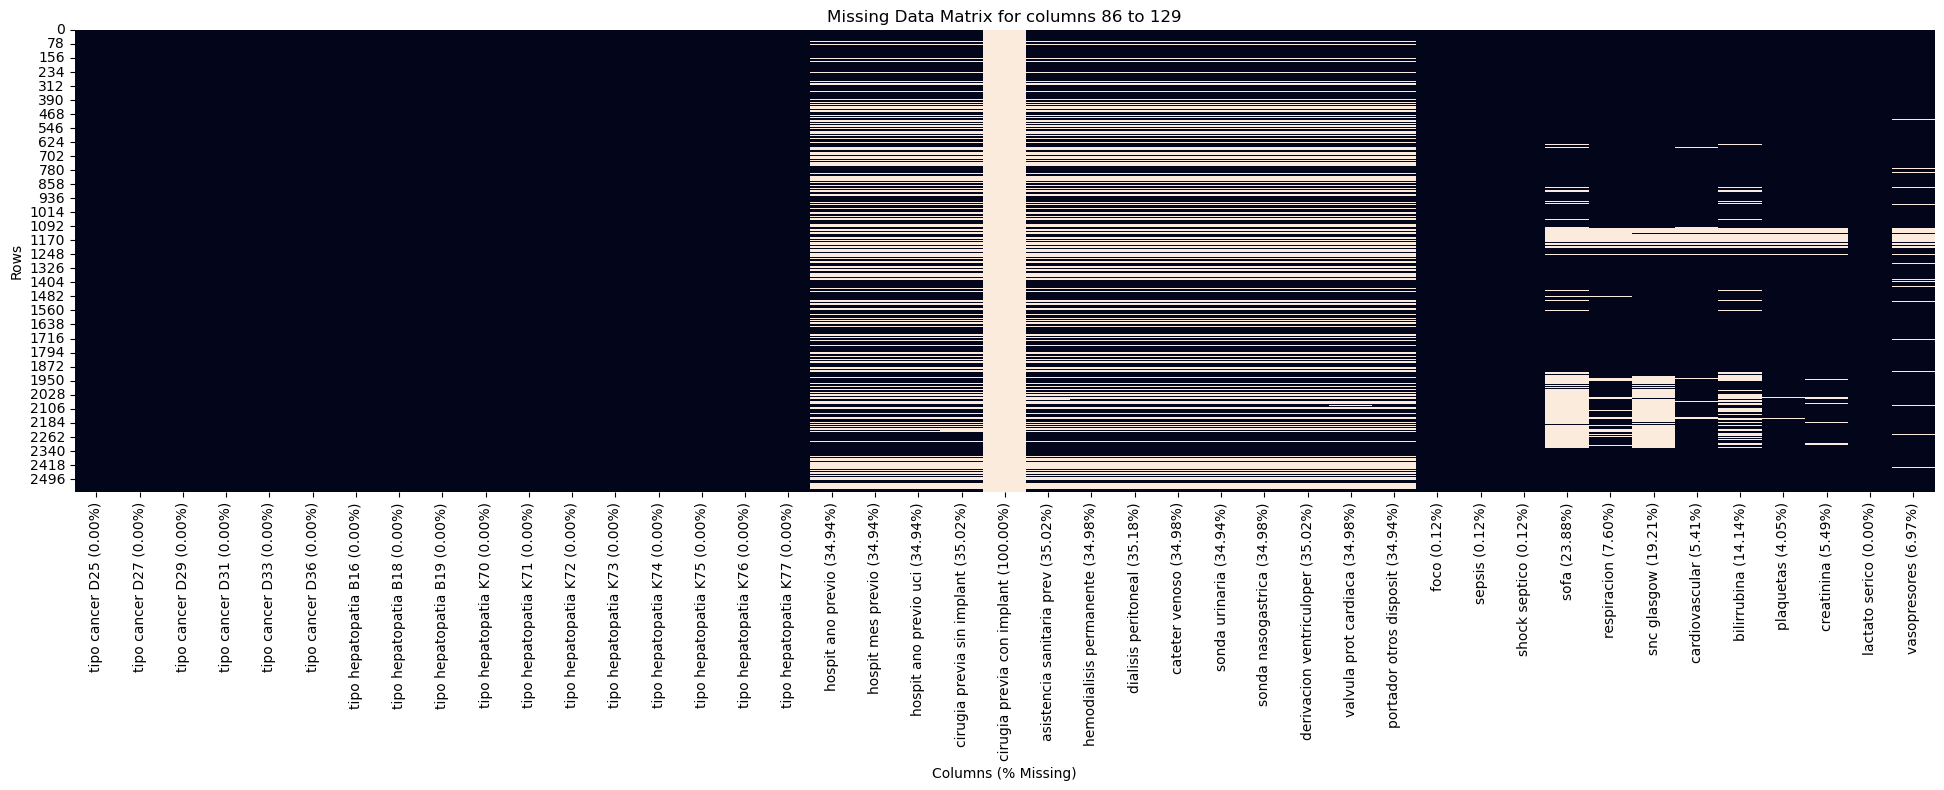

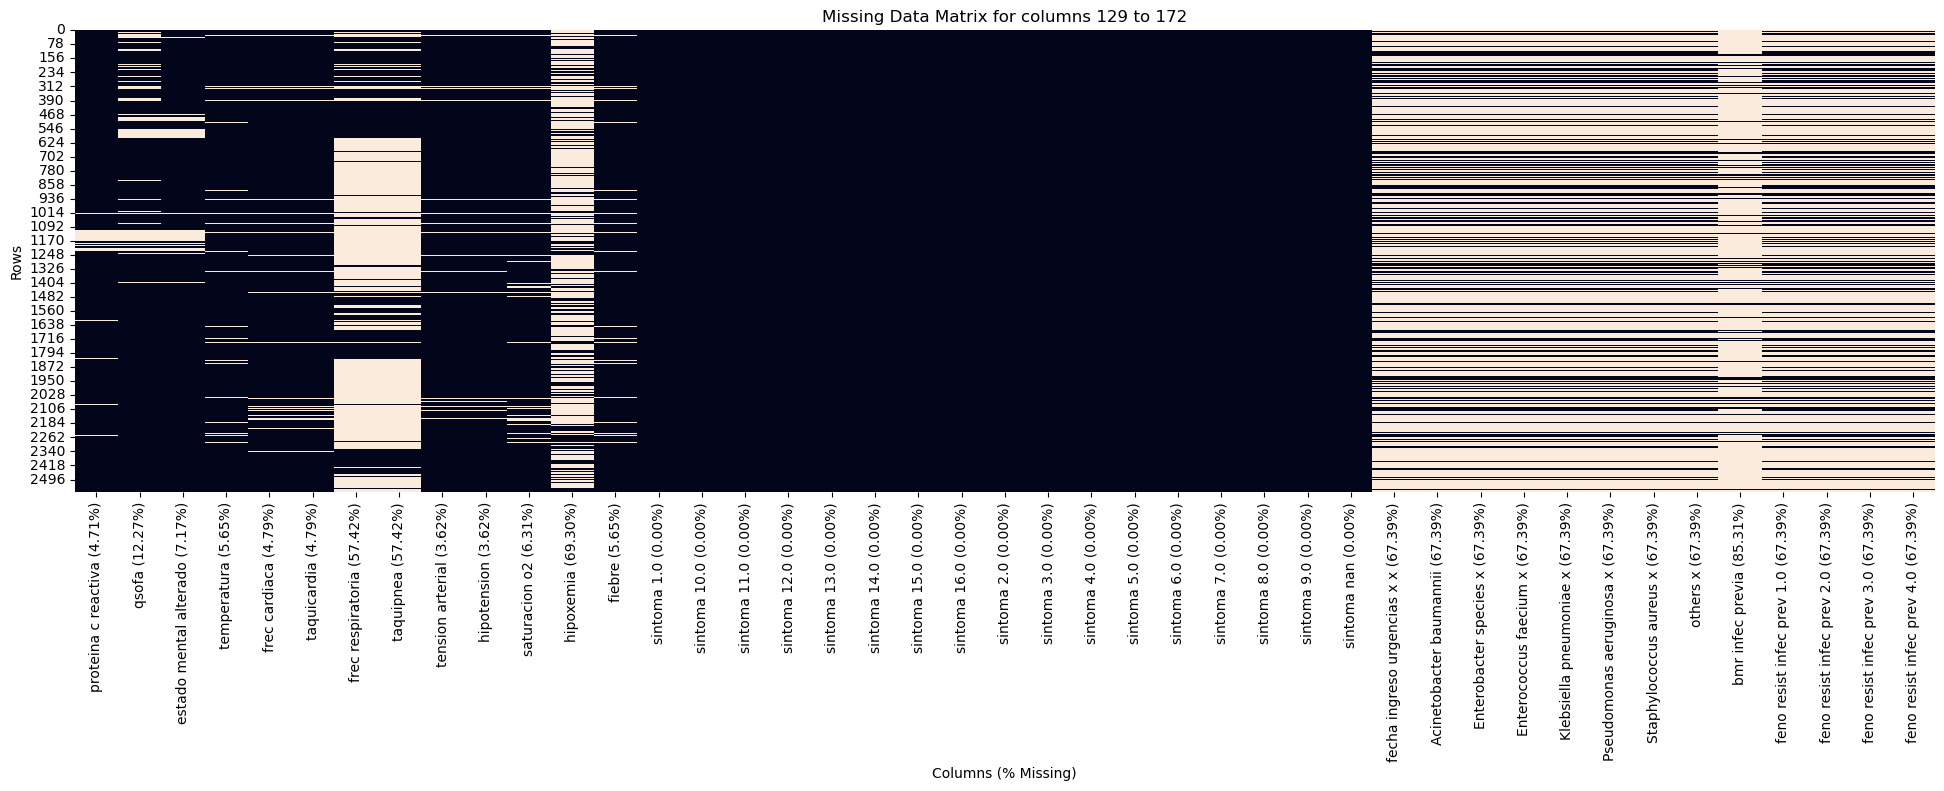

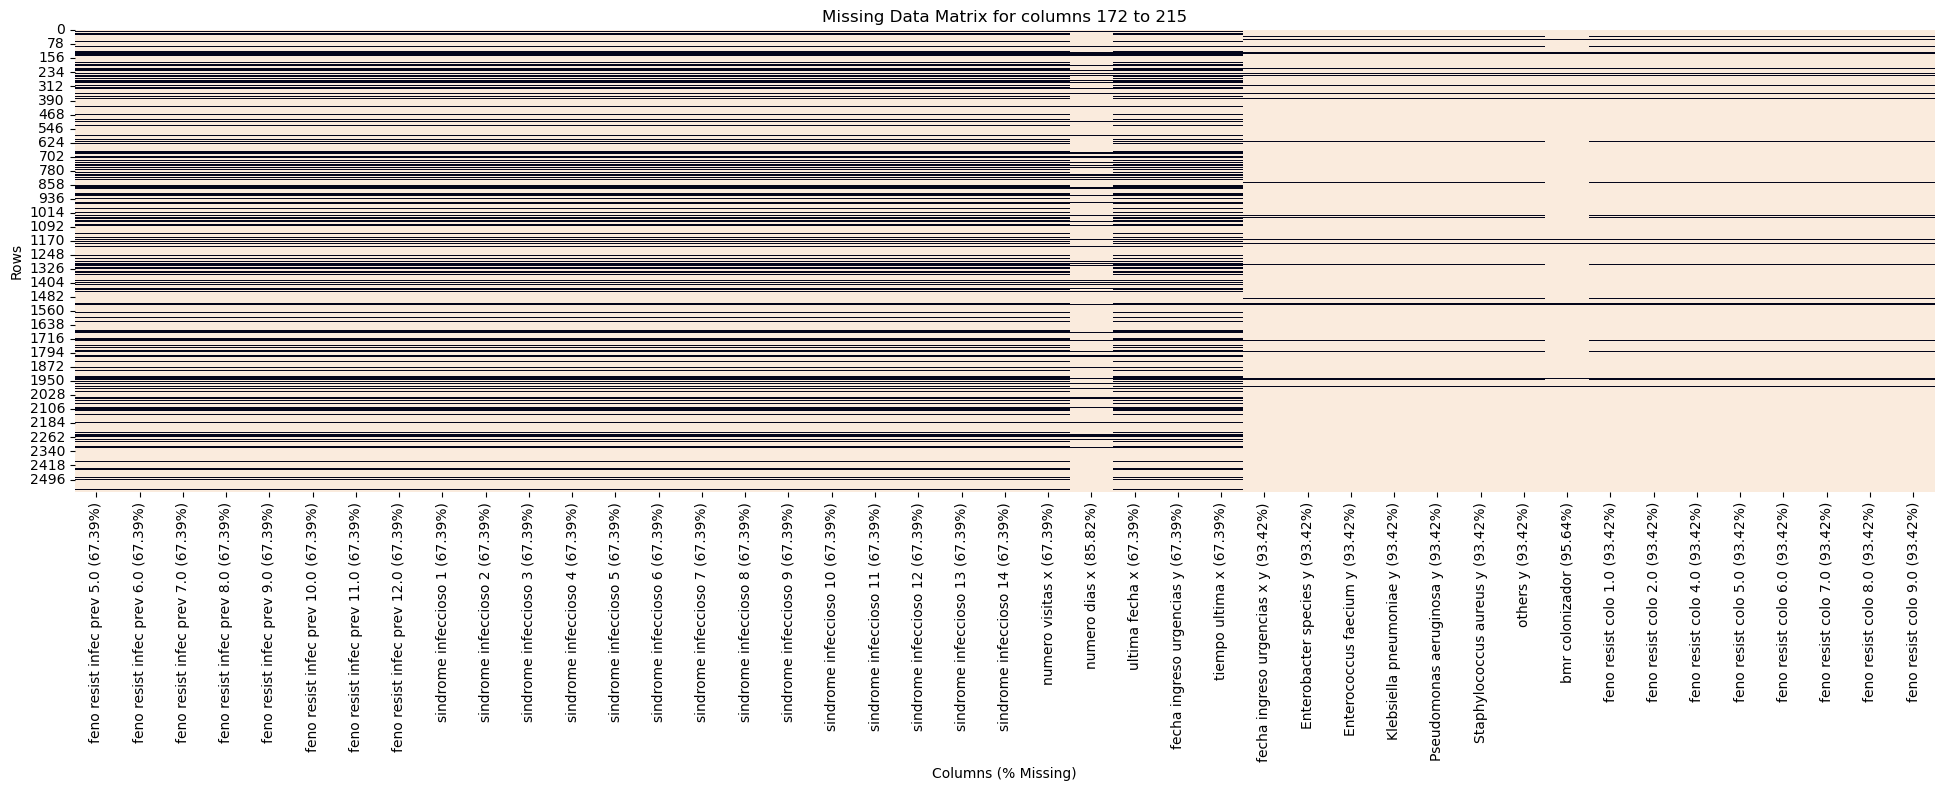

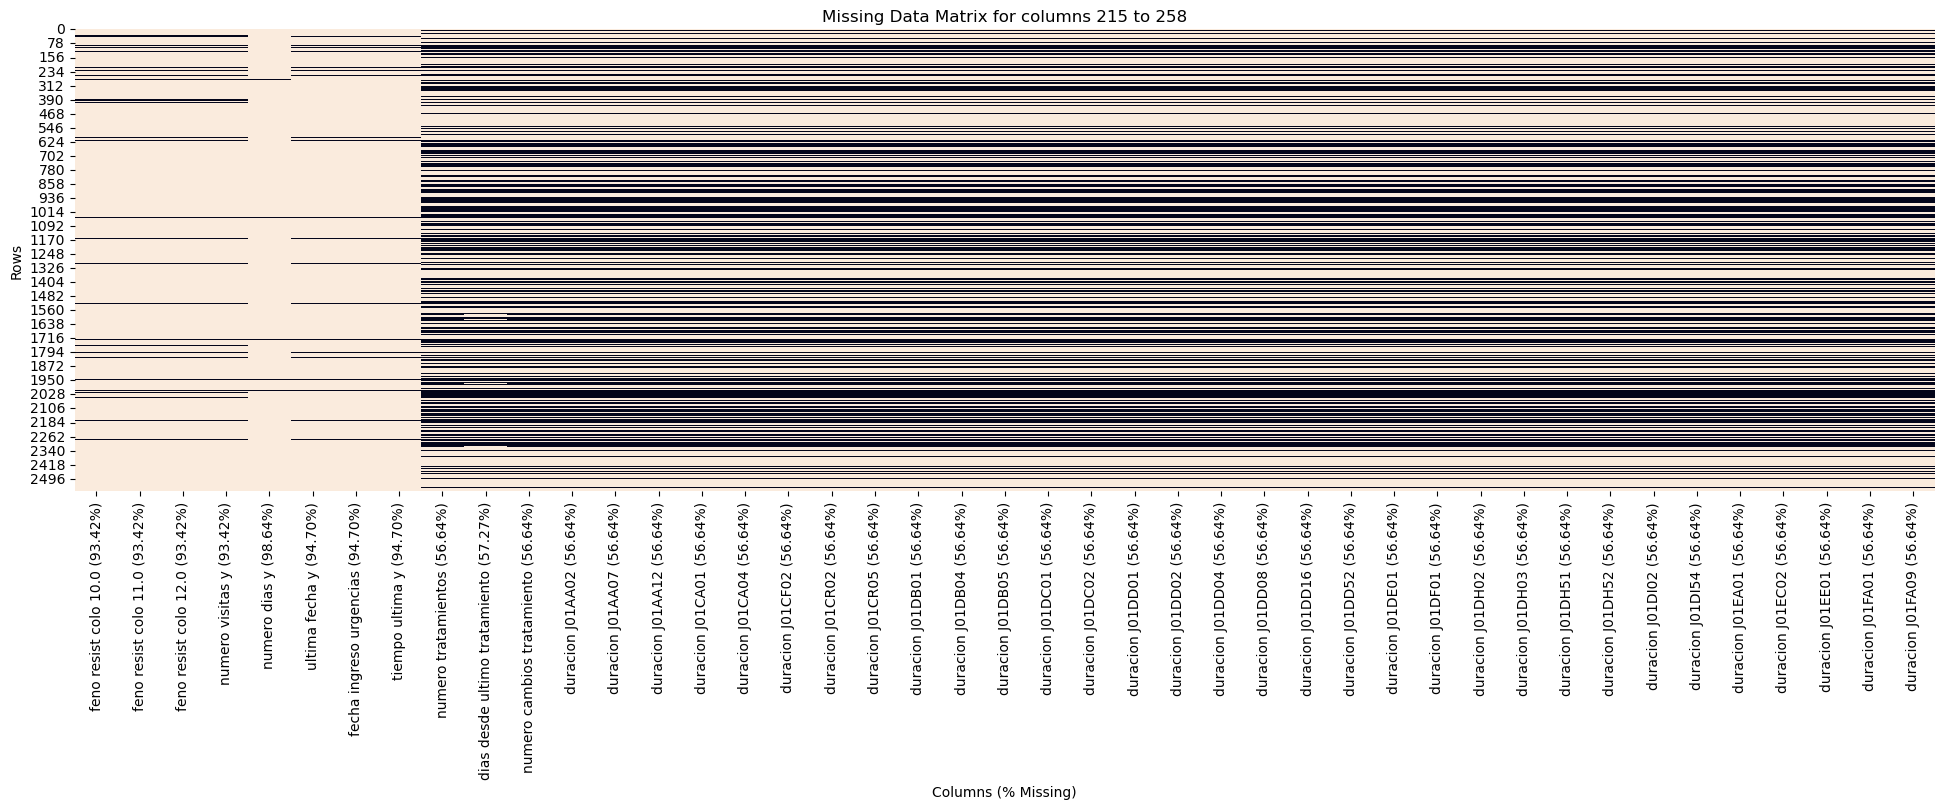

In [133]:

prev_num = 0
for new_num in range(43, 288, 43):
    if new_num > len(df_merged.columns):
        new_num = len(df_merged.columns)
    subset_df = df_merged.iloc[:, prev_num:new_num]
    missing_df = subset_df.isna()
    missing_df.columns = subset_df.columns
    missing_percent = missing_df.mean() * 100
    
    columns_with_percent = [
        f"{col.replace('_', ' ')} ({missing_percent[col]:.2f}%)" if missing_percent[col] > 30 
        else f"{col.replace('_', ' ')} ({missing_percent[col]:.2f}%)"
        for col in subset_df.columns
    ]
    
    plt.figure(figsize=(24, 6))
    sns.heatmap(missing_df, vmin=0, vmax=1, cbar=False,
                xticklabels=columns_with_percent)
    plt.title(f"Missing Data Matrix for columns {prev_num} to {new_num}")
    plt.xlabel("Columns (% Missing)")
    plt.ylabel("Rows")
    plt.show()
    
    if new_num == len(df_merged.columns):
        break
    prev_num = new_num
